<a href="https://colab.research.google.com/github/ngupta1137/MachineLearning_FinalProject/blob/main/Pneumonia_Detection_ML_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-ray Images Using Deep Learning

Dataset [Kaggle - Chest X-ray Images(Pneumonia](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) 


In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import os
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import opendatasets as od

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import random
from pathlib import Path 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mimg # images
%matplotlib inline
import seaborn as sns
import plotly.express as px
import keras
import tensorflow as tf
import cv2
import imgaug as aug
import imgaug.augmenters as iaa

from tensorflow.compat.v1 import Session, ConfigProto, set_random_seed
from tensorflow.python.client import device_lib
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.applications.inception_v3 import InceptionV3
from keras.constraints import maxnorm
from keras import backend as K
from skimage.io import imread
from skimage.transform import resize
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from PIL import Image

In [3]:
od.download("https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ngupta1137
Your Kaggle Key: ··········


100%|██████████| 2.29G/2.29G [01:49<00:00, 22.4MB/s]


In [4]:
base_directory = Path("chest-xray-pneumonia/chest_xray/chest_xray/")

In [5]:
train_directory = base_directory /"train/" 
val_directory = base_directory /"val/"
test_directory = base_directory /"test/"

In [6]:
os.listdir(train_directory)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [7]:
train_normal_directory = train_directory /"NORMAL"
train_pneumonia_directory = train_directory /"PNEUMONIA"

In [8]:
os.listdir(val_directory)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [9]:
valid_normal_directory = val_directory /"NORMAL" 
valid_pneumonia_directory = val_directory /"PNEUMONIA"

In [10]:
os.listdir(test_directory)

['PNEUMONIA', 'NORMAL', '.DS_Store']

In [11]:
test_normal_directory = test_directory /"NORMAL" 
test_pneumonia_directory = test_directory /"PNEUMONIA"

In [12]:
train_normal= train_normal_directory.glob("*.jpeg") 
train_pneumonia=train_pneumonia_directory.glob("*.jpeg") 
train_set=[]

In [13]:
for img in train_normal: 
  train_set.append((img, 0)) 
for img in train_pneumonia:
  train_set.append((img, 1)) 

In [14]:
train_set=pd.DataFrame(train_set, columns=["image", "label"], index=None)

In [15]:
train_set.head() 

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,0


In [16]:
train_set=train_set.sample(frac=1) 
train_set=train_set.reset_index(drop=True)
train_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
2,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/tra...,1


In [17]:
valid_normal= valid_normal_directory.glob("*.jpeg") 
valid_pneumonia=valid_pneumonia_directory.glob("*.jpeg") 
valid_set=[] 

In [18]:
for img in valid_normal: 
  valid_set.append((img, 0))
for img in valid_pneumonia:
  valid_set.append((img, 1))


In [19]:
valid_set=pd.DataFrame(valid_set, columns=["image", "label"], index=None)
valid_set.head() 

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [20]:
valid_set=valid_set.sample(frac=1) 
valid_set=valid_set.reset_index(drop=True)
valid_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/val...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/val...,1
4,chest-xray-pneumonia/chest_xray/chest_xray/val...,0


In [21]:
test_normal= test_normal_directory.glob("*.jpeg") 
test_pneumonia=test_pneumonia_directory.glob("*.jpeg")
test_set=[]

In [22]:
for img in test_normal: 
  test_set.append((img, 0)) 
for img in test_pneumonia:
  test_set.append((img, 1)) 

In [23]:
test_set=pd.DataFrame(test_set, columns=["image", "label"], index=None)
test_set.head() 

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0


In [24]:
test_set=test_set.sample(frac=1)
test_set=test_set.reset_index(drop=True) 
test_set.head()

,image,label
0,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
1,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
2,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1
3,chest-xray-pneumonia/chest_xray/chest_xray/tes...,0
4,chest-xray-pneumonia/chest_xray/chest_xray/tes...,1


In [25]:
train_normal_count= train_set.loc[train_set["label"]==0]["image"].count()
print("Total number of normal images:", train_normal_count)

Total number of normal images: 1341


In [26]:
train_pneumonia_count= train_set.loc[train_set["label"]==1]["image"].count()
print("Total number of pneumonia images:", train_pneumonia_count)

Total number of pneumonia images: 3875


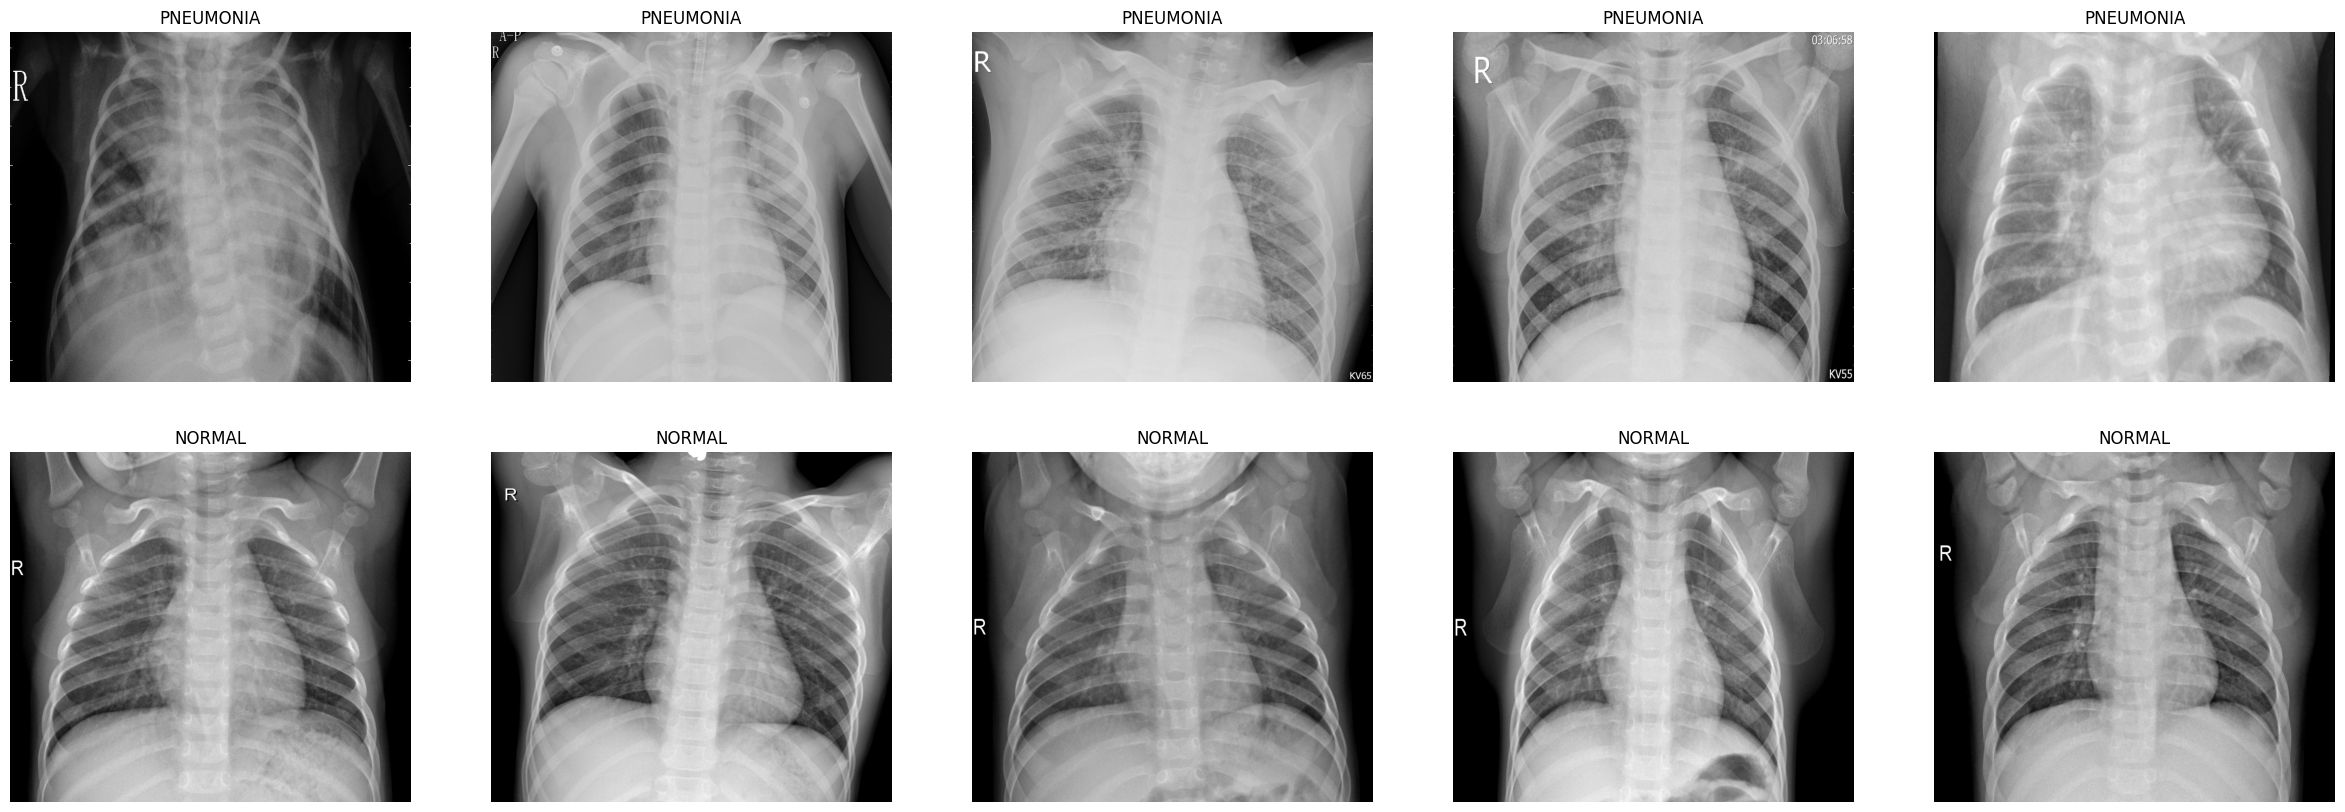

In [27]:
pneumonia_samples = (train_set[train_set["label"] == 1]["image"].iloc[:5]).tolist()
normal_samples = (train_set[train_set["label"] == 0]["image"].iloc[:5]).tolist()
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples
f, ax = plt.subplots(2,5, figsize = (30,10))

for i in range(10):
    img = imread(samples[i])
    ax[i//5, i % 5].imshow(img, cmap='gray')
    if i < 5:
        ax[i//5, i % 5].set_title("PNEUMONIA")
    else:
        ax[i//5, i % 5].set_title("NORMAL")
    ax[i//5, i % 5].axis('off')
    ax[i//5, i % 5].set_aspect('auto')
plt.show()

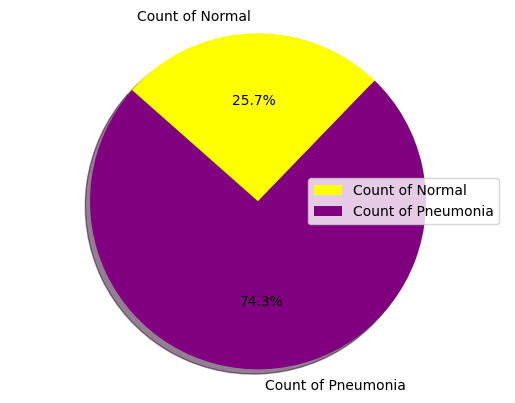

In [28]:
fig1,ax1= plt.subplots()
sizes=[train_normal_count, train_pneumonia_count]
ax1.pie(sizes, startangle=46 ,labels=["Count of Normal","Count of Pneumonia"], autopct="%1.1f%%", shadow=True, colors=["yellow","purple"])
ax1.axis("equal")
plt.legend()
plt.show()

Text(0.5, 1.0, 'Normal vs Pnumonia Total')

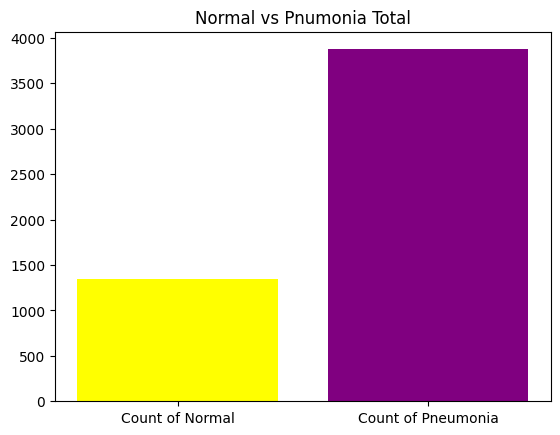

In [29]:
fig2, ax2=plt.subplots()
ax2.bar(height=sizes, x=["Count of Normal", "Count of Pneumonia"], color=["yellow", "purple"])
plt.title("Normal vs Pnumonia Total")

In [30]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_data(data_directory):
    data = []
    for label in labels:
        path = os.path.join(data_directory, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)


In [31]:
train = get_data(train_directory)
test = get_data(test_directory)
val = get_data(val_directory)

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



<ipython-input-30-41384a8cc77e>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.7.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [32]:
X_train, X_val, X_test = ([], ) * 3
y_train, y_val, y_test = ([], ) * 3

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)

In [33]:
X_train = np.array(X_train) /255
X_val = np.array(X_val) / 255
X_test = np.array(X_test) / 255

In [34]:
X_train = X_train.reshape (-1, img_size, img_size, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [35]:
image_generator = ImageDataGenerator(
  featurewise_center = False, 
  samplewise_center = False, 
  featurewise_std_normalization = False, 
  samplewise_std_normalization = False, 
  zca_whitening=False, 
  rotation_range =30, 
  zoom_range = 0.2, 
  width_shift_range = 0.1, 
  height_shift_range = 0.1, 
  horizontal_flip = True,
  vertical_flip = False)
  
image_generator.fit(X_train)

In [36]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [37]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [38]:
history = model.fit(image_generator.flow(X_train, y_train, batch_size=32), epochs=15, validation_data=image_generator.flow(X_val, y_val), callbacks=[learning_rate_reduction])

Epoch 1/15
183/183 [==============================] - 37s 128ms/step - loss: 0.5686 - accuracy: 0.8333 - val_loss: 9.0504 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 2/15
183/183 [==============================] - 24s 133ms/step - loss: 0.2779 - accuracy: 0.8926 - val_loss: 10.7966 - val_accuracy: 0.7297 - lr: 0.0010
Epoch 3/15
183/183 [==============================] - 23s 128ms/step - loss: 0.2356 - accuracy: 0.9129 - val_loss: 0.3972 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 4/15
183/183 [==============================] - 24s 129ms/step - loss: 0.2189 - accuracy: 0.9214 - val_loss: 2.3013 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 5/15
183/183 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.9319
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
183/183 [==============================] - 23s 127ms/step - loss: 0.2071 - accuracy: 0.9319 - val_loss: 0.9866 - val_accuracy: 0.7799 - lr: 0.0010
Epoch 6/15
183/183 [============================

In [39]:
print("Model Loss: " , model.evaluate(X_test,y_test)[0])
print("Model Accuracy: " , model.evaluate(X_test,y_test)[1]*100 , "%")

183/183 [==============================] - 2s 10ms/step - loss: 0.1340 - accuracy: 0.9489
Model Loss:  0.13398377597332
183/183 [==============================] - 2s 10ms/step - loss: 0.1340 - accuracy: 0.9489
Model Accuracy:  94.89412307739258 %


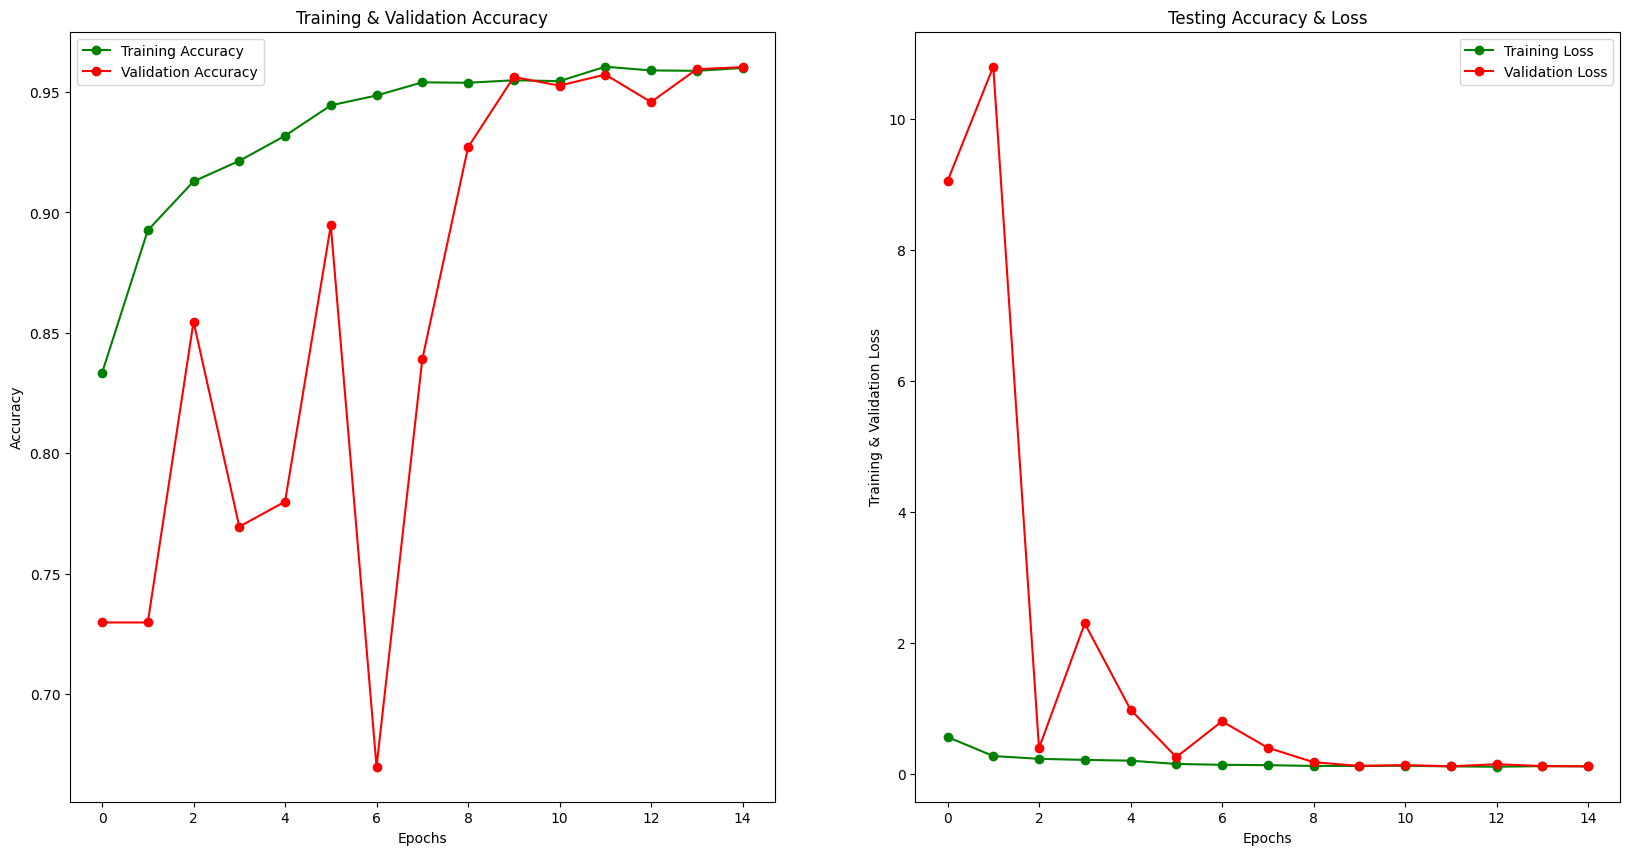

In [40]:
epochs = [i for i in range(15)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [41]:
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1, -1)[0]

183/183 [==============================] - 2s 8ms/step


In [42]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia','Normal']))

              precision    recall  f1-score   support

   Pneumonia       0.99      0.94      0.96      4273
      Normal       0.86      0.97      0.91      1583

    accuracy                           0.95      5856
   macro avg       0.92      0.96      0.94      5856
weighted avg       0.95      0.95      0.95      5856



In [43]:
cm = confusion_matrix(y_test, predictions)
cm

array([[4016,  257],
       [  42, 1541]])

In [44]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

<Axes: >

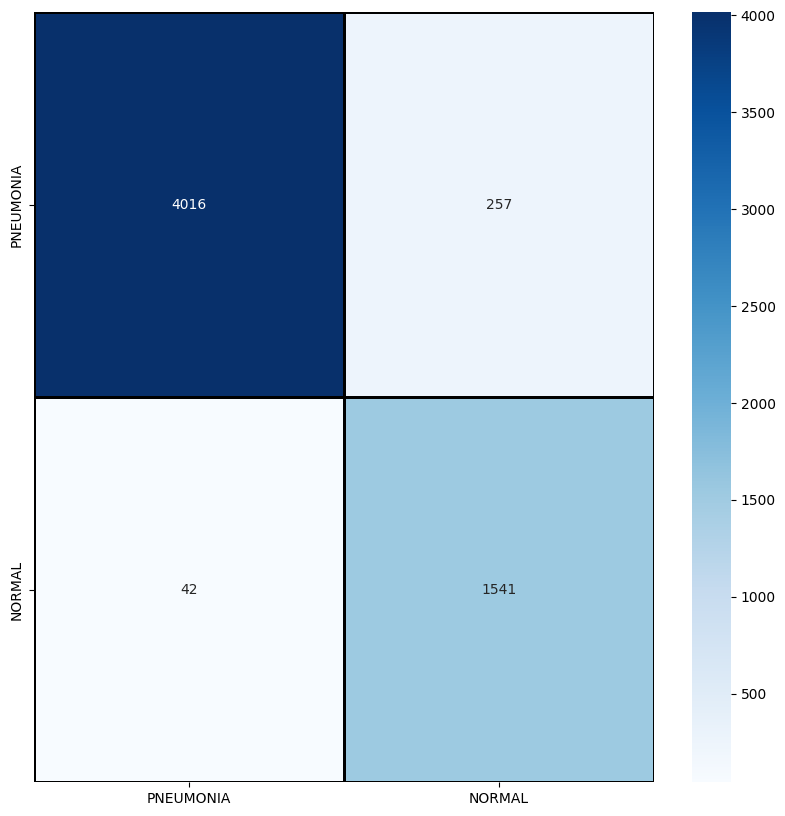

In [45]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)